In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle

In [2]:
data_paths = {  'ntp' : '../verisetleri/ntp.pkl',
                'udp' : '../verisetleri/udp.pkl',
                'syn' : '../verisetleri/syn.pkl',}

dataset_dict = {    'ntp' : None, 'udp' : None,
                    'syn' : None}

In [3]:
def upload_dataset_with_time(path:str):
    startingT = time.perf_counter()
    if 'pkl' in path:
        veriseti = pd.read_pickle(path)
    else:
        veriseti = pd.read_csv(path, low_memory=False)
    endingT = time.perf_counter()
    print(f"Dataset is loaded in {endingT - startingT} seconds")
    return veriseti

In [4]:
for data_name, path in data_paths.items():
    data = upload_dataset_with_time(path)
    dataset_dict[data_name] = data.copy()

Dataset is loaded in 0.9732956000000001 seconds
Dataset is loaded in 2.878026900000002 seconds
Dataset is loaded in 1.5735545000000002 seconds


## 1. Veriseti İşlemleri

CiC veriseti 2 farklı atak tipini içeriyor.<br> 
1- Reflection Attacks<br>
2- Exploitation Attacks<br><br>

Explotitation : Syn Flood , UDP Flood<br>
Reflection : NTP <br>
Ataklarını alarak işlemlere başladık. İlk olarak bu veriseti flow based kaydedilmiş.<br>
Matrix Profile ile incelemek için, data paketlerini bir time series'e dönüştürme işlemi gerçekleştirdim.<br>
Bunu yaparken, ilk olarak saniye cinsinden flowları grupladım.<br>

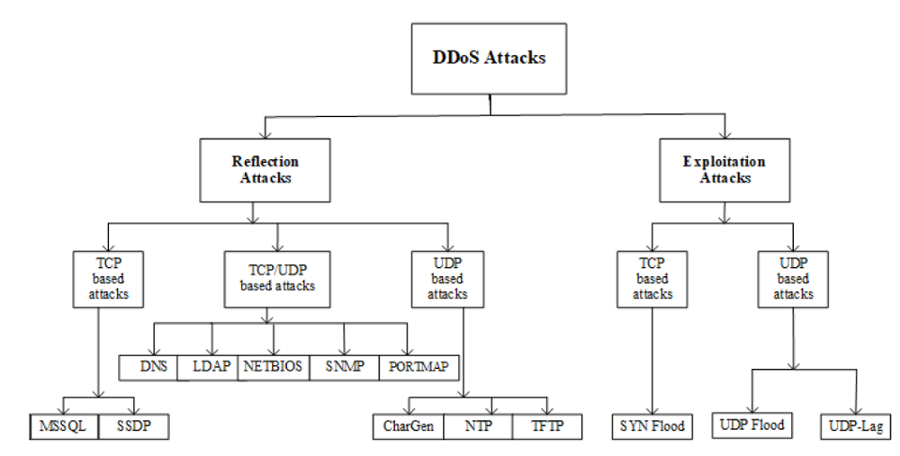

In [10]:
from IPython.display import Image
Image('gorseller/ddos_attacks.png',  width=700, height=450)

#### İşlenmeden önceki Syn Flood veriseti

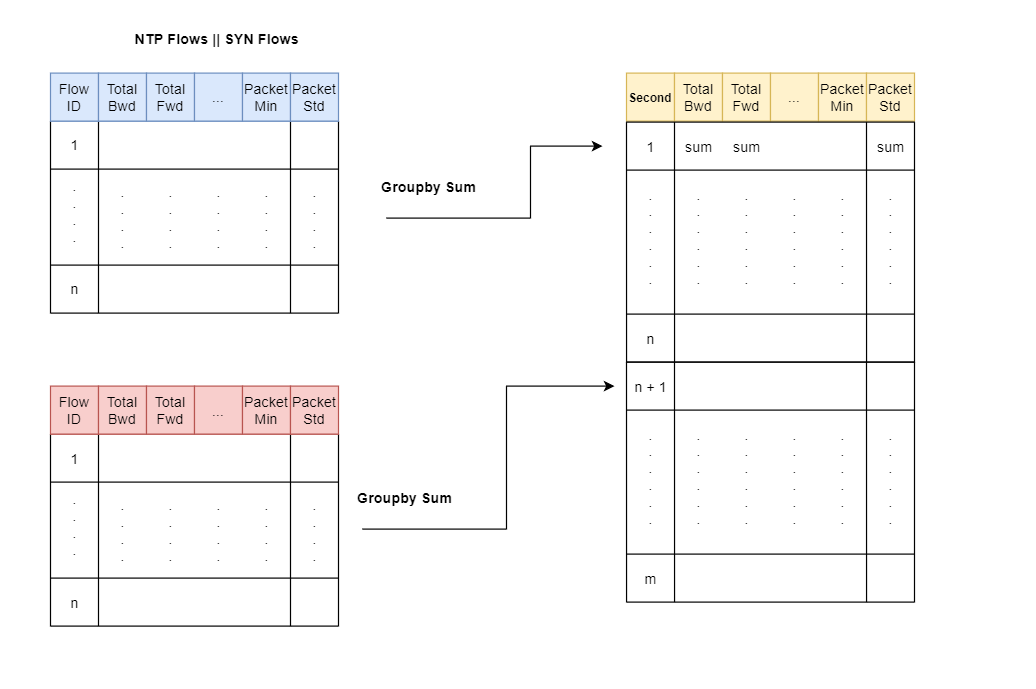

In [24]:
Image('gorseller/data_process_seconds.png', width=800, height=400)

In [13]:
display(dataset_dict["syn"].iloc[:5,1:12])

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets
0,172.16.0.5-192.168.50.1-53058-53058-6,172.16.0.5,53058,192.168.50.1,53058,6,2018-12-01 13:30:30.741451,115799309,19,2,0.0
1,172.16.0.5-192.168.50.1-32237-32237-6,172.16.0.5,32237,192.168.50.1,32237,6,2018-12-01 13:30:30.741452,113973933,16,0,0.0
2,172.16.0.5-192.168.50.1-60495-9840-6,172.16.0.5,60495,192.168.50.1,9840,6,2018-12-01 13:30:30.741501,112,2,2,0.0
3,172.16.0.5-192.168.50.1-59724-59724-6,172.16.0.5,59724,192.168.50.1,59724,6,2018-12-01 13:30:30.741563,105985004,16,0,0.0
4,172.16.0.5-192.168.50.1-60496-32538-6,172.16.0.5,60496,192.168.50.1,32538,6,2018-12-01 13:30:30.741565,1,2,0,0.0


In [14]:
print(f"row data sayisi: {dataset_dict['syn'].shape[0]}\nFeature sayisi : {dataset_dict['syn'].shape[1]}")

row data sayisi: 1582681
Feature sayisi : 88


In [15]:
data_paths_by_seconds = {   'ntp' : 'ntp_by_seconds_data.csv',
                            'syn' : 'ddos_dataset_on_seconds.csv',}

dataset_dict_by_seconds = {     'ntp' : None,
                                'syn' : None}

for data_name, path in data_paths_by_seconds.items():
    data = upload_dataset_with_time(path)
    dataset_dict_by_seconds[data_name] = data.copy()

Dataset is loaded in 0.02692650000000185 seconds
Dataset is loaded in 0.12758139999999685 seconds


In [16]:
ntp_df = dataset_dict_by_seconds["ntp"]
syn_df = dataset_dict_by_seconds["syn"]

ntp_df["Label"] = ntp_df["Label"].apply(lambda x: 1 if x > 20 else 0)
ddos_ntp = ntp_df[ntp_df["Label"] == 1].sample(524).reset_index(drop=True)
ddos_ntp = ddos_ntp[[*(syn_df.columns)]]

In [17]:
display(syn_df.iloc[:5,:12])

,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std
0,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,856774.251777,763813.140469
1,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,620945.237430,495483.903260
2,34521.0,31317.0,3365823.0,12264572.0,755249.0,98726.0,232068.791277,220896.861116,1718078.0,221093.0,576090.176283,459343.769471
3,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,856774.251777,763813.140469
4,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,620945.237430,495483.903260


In [20]:
syn_slice_1 = syn_df.iloc[:12000, :].copy()
syn_slice_2 = syn_df.iloc[12000:, :].copy()
merged_df = pd.concat([syn_slice_1, ddos_ntp ,syn_slice_2, ddos_ntp, syn_slice_2], axis = 0).reset_index(drop=True)
df = merged_df.copy()

In [29]:
def plot_ddos(df: pd.DataFrame, attack_number:int=0):
    xAxis = list(range(len(df)))
    yAxis = df["Label"].to_list()
    # Create a figure
    fig = plt.figure(figsize=(25,15))
    # Add a subplot
    ax = fig.add_subplot()
    ax.plot(xAxis, yAxis)
    rect_list = [    Rectangle((7200, 0), 300, 1, facecolor='lightgreen'), 
                     Rectangle((12000, 0), 524, 1, facecolor='red'),
                     Rectangle((12524 + 6238 , 0), 300, 1, facecolor='lightgreen'),
                     Rectangle((12000 + 13676 + 524, 0), 524, 1, facecolor='red'),
                     Rectangle((12000 + 13676 + 524 + 524 + 6238, 0), 300, 1, facecolor='lightgreen')   ]
   
    for i in range(0,attack_number):
        ax.add_patch(rect_list[i])
    
    plt.ylabel('Label')
    plt.xlabel('Seconds')
    plt.title('Network Traffic')
    plt.show()

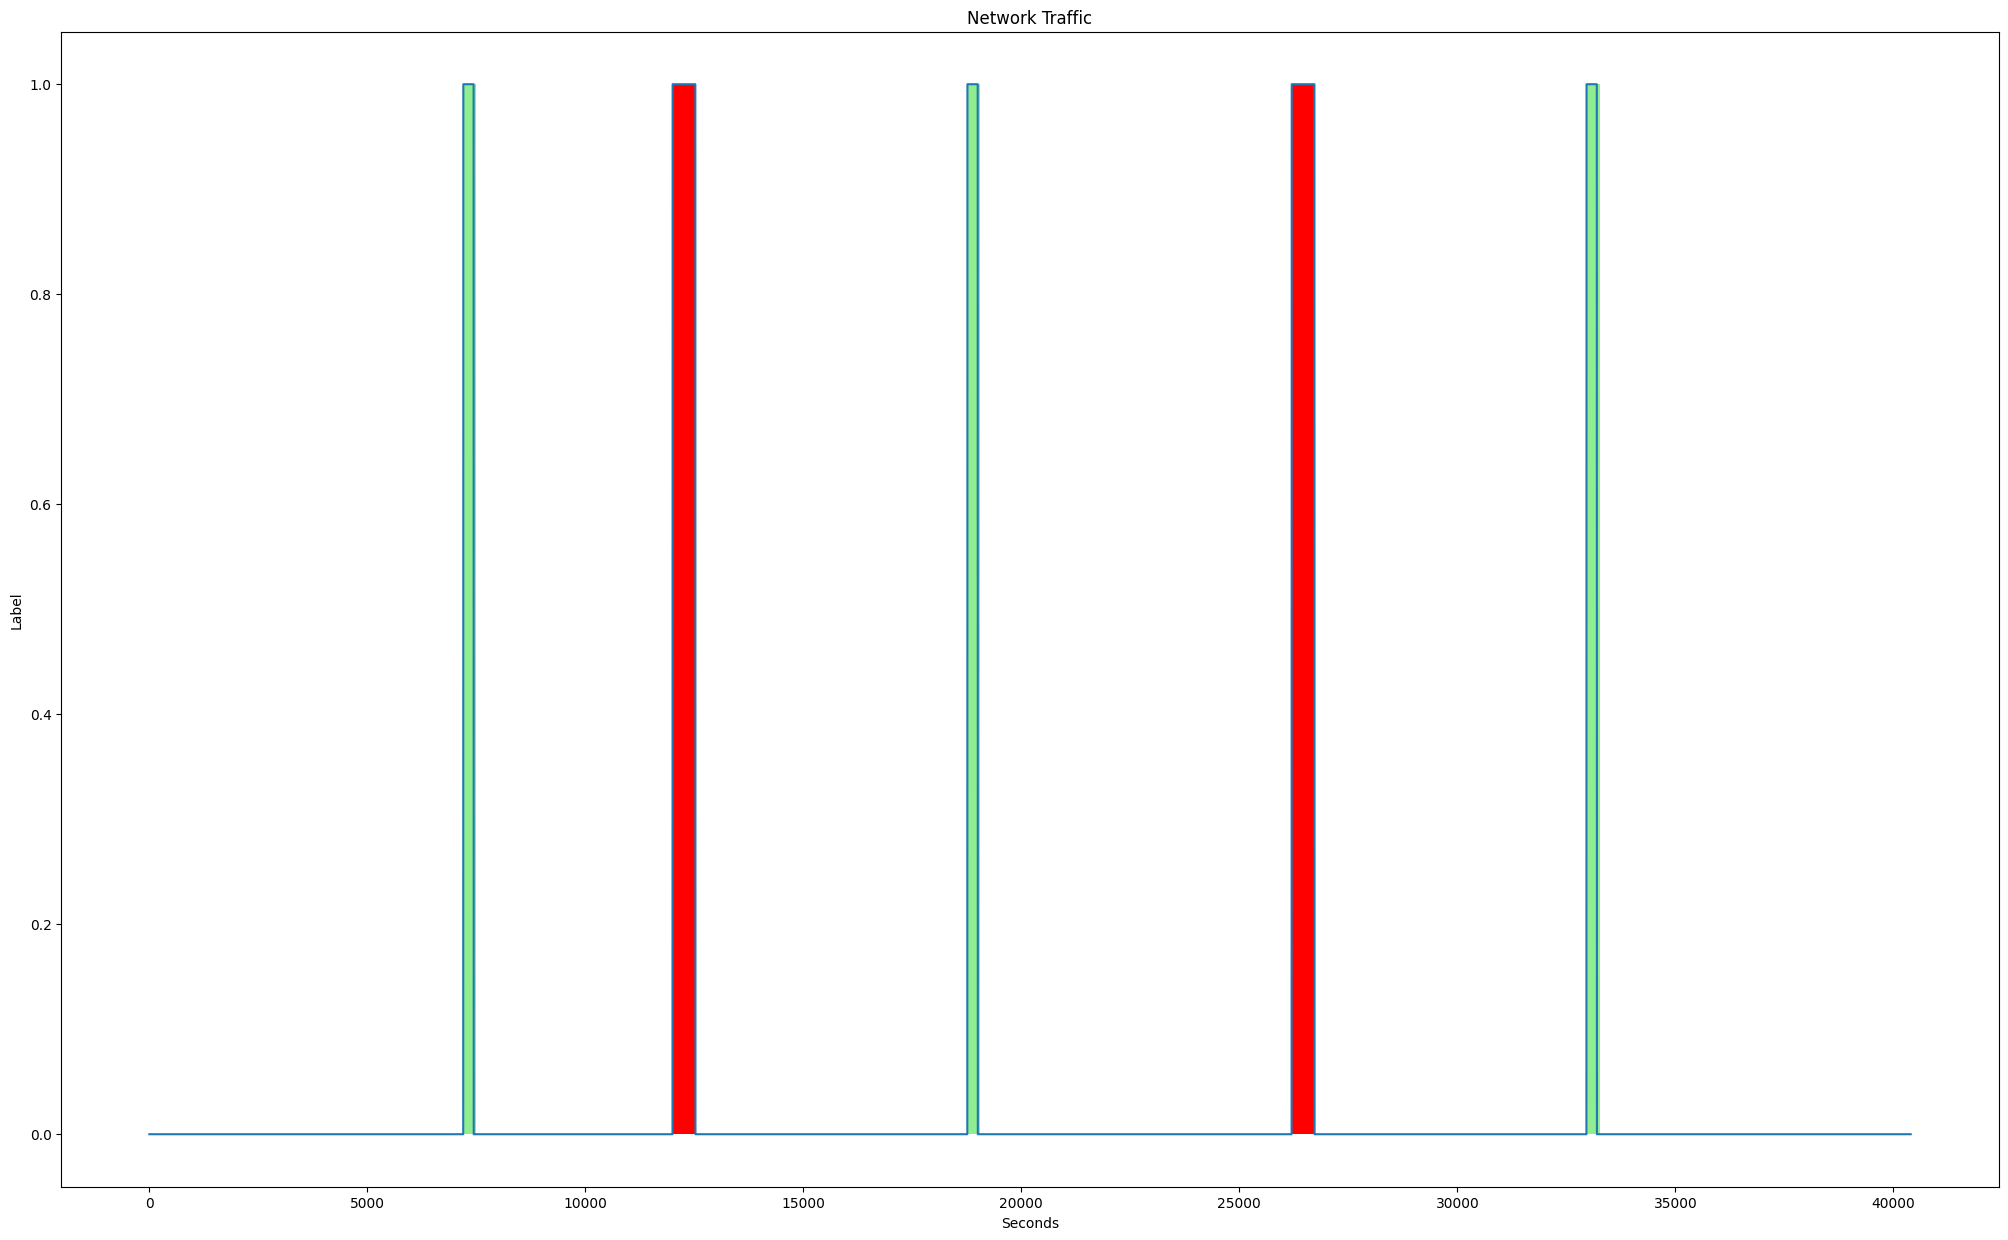

In [30]:
plot_ddos(df, attack_number=5)

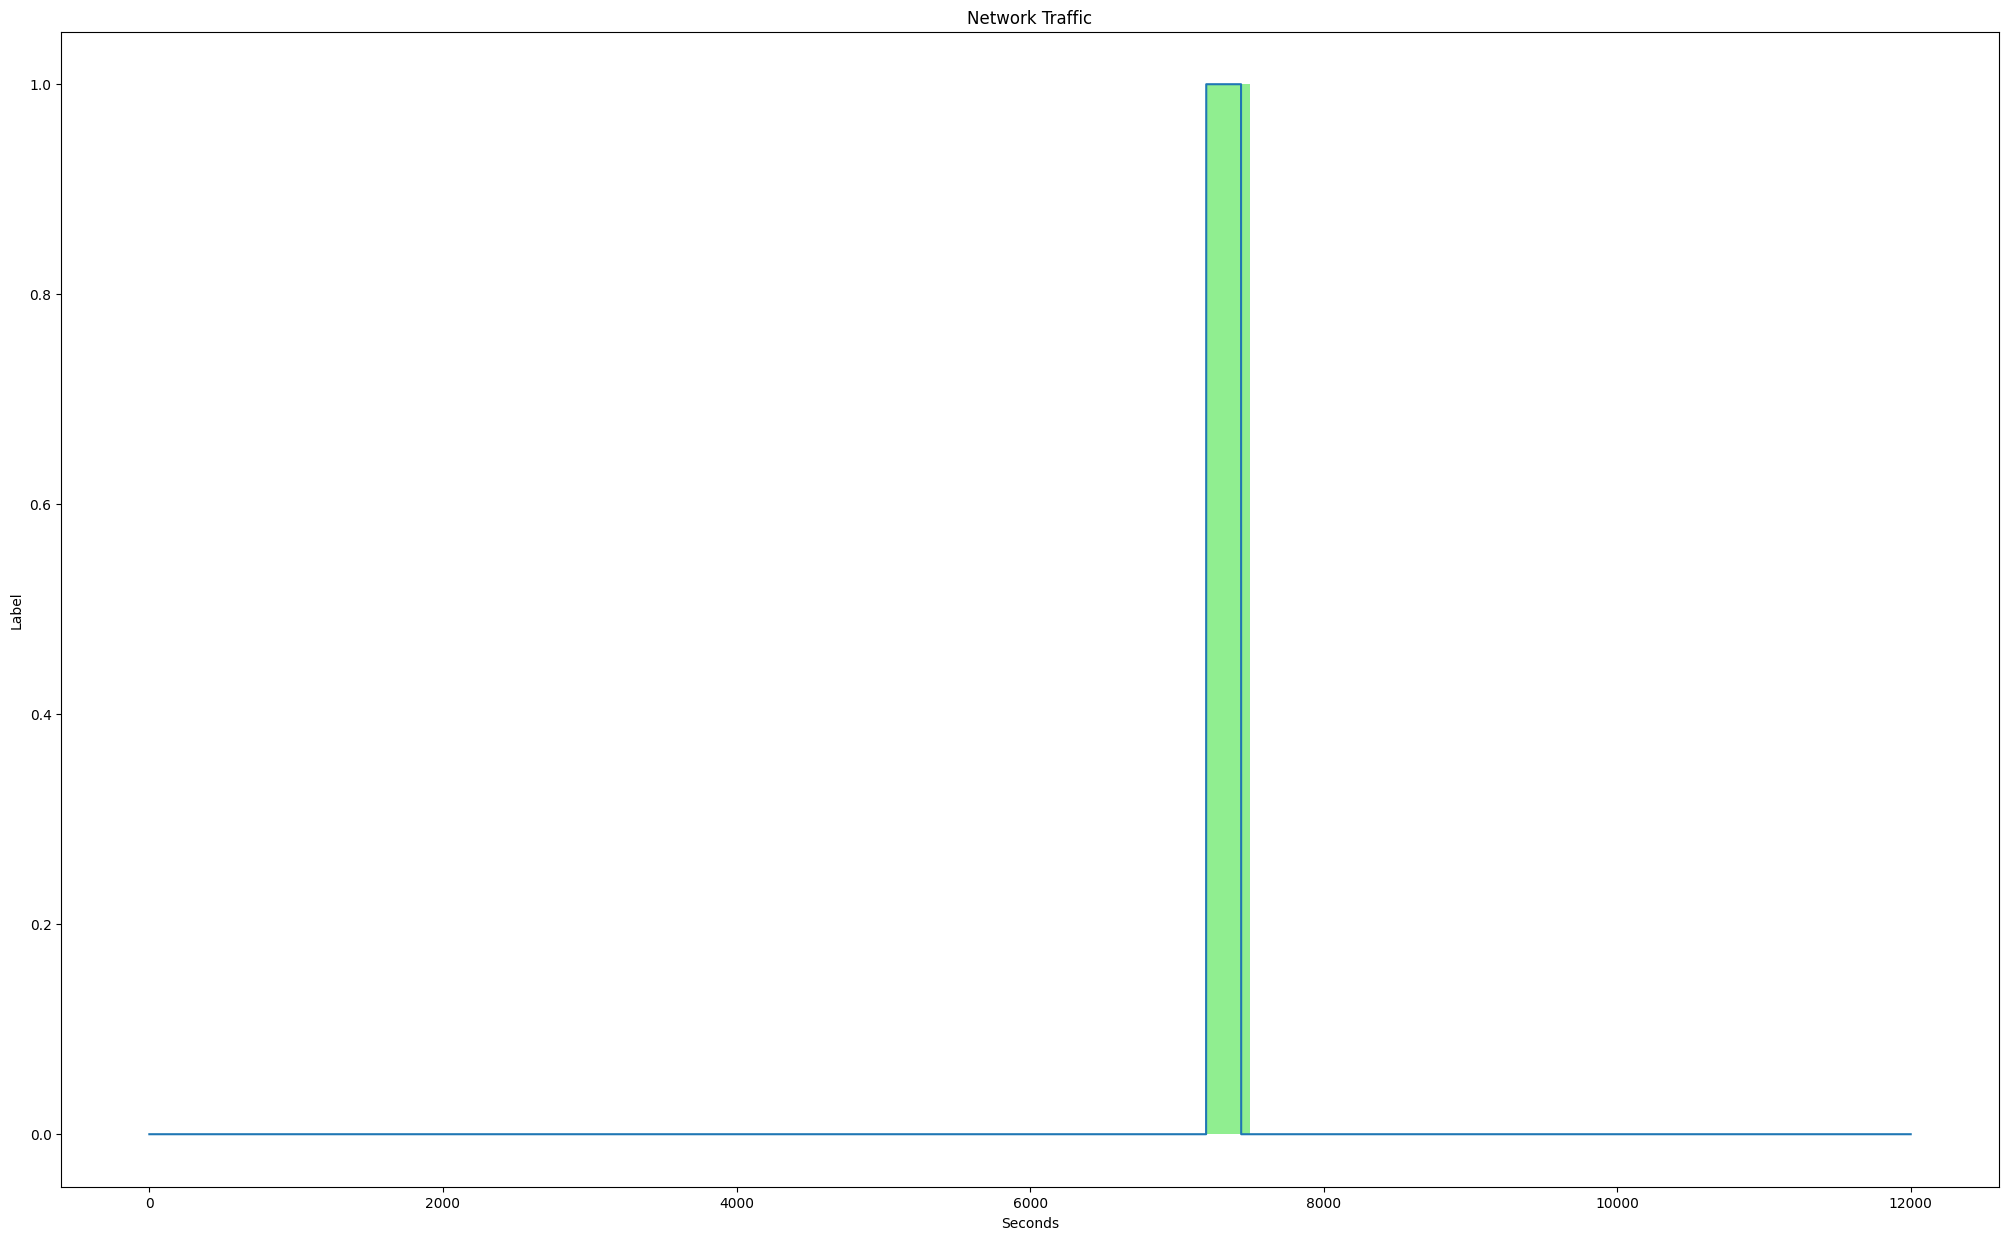

In [31]:
plot_ddos(syn_slice_1, attack_number=1)

In [32]:
["Fwd Packets/s"]

,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Label
0,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,...,1.003700e+06,1.523404e+06,7.184094e+08,3.907212e+07,99474.0,3394840.0,610452.099664,795468.719934,9.985600e+08,0
1,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,...,8.039800e+05,8.288560e+05,7.930575e+08,1.786188e+07,107214.0,2063759.0,436648.922880,530980.392343,3.077283e+08,0
2,34521.0,31317.0,3365823.0,12264572.0,755249.0,98726.0,232068.791277,220896.861116,1718078.0,221093.0,...,-2.550454e+10,-2.550455e+10,1.127396e+09,1.957448e+07,94632.0,1893322.0,417656.758716,505439.642372,2.923933e+08,0
3,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,...,1.003700e+06,1.523404e+06,7.184094e+08,3.907212e+07,99474.0,3394840.0,610452.099664,795468.719934,9.985600e+08,0
4,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,...,8.039800e+05,8.288560e+05,7.930575e+08,1.786188e+07,107214.0,2063759.0,436648.922880,530980.392343,3.077283e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,...,1.003700e+06,1.523404e+06,7.184094e+08,3.907212e+07,99474.0,3394840.0,610452.099664,795468.719934,9.985600e+08,0
11996,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,...,8.039800e+05,8.288560e+05,7.930575e+08,1.786188e+07,107214.0,2063759.0,436648.922880,530980.392343,3.077283e+08,0
11997,34521.0,31317.0,3365823.0,12264572.0,755249.0,98726.0,232068.791277,220896.861116,1718078.0,221093.0,...,-2.550454e+10,-2.550455e+10,1.127396e+09,1.957448e+07,94632.0,1893322.0,417656.758716,505439.642372,2.923933e+08,0
11998,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,...,1.003700e+06,1.523404e+06,7.184094e+08,3.907212e+07,99474.0,3394840.0,610452.099664,795468.719934,9.985600e+08,0


In [127]:
import pandas as pd
import numpy as np
import stumpy
import random

class MatrixProfileManager:
    if 'global_df' not in dir():
        global_df = None

    THRESHOLD_BASE_ACTIVE = False
    threshold = 5.0

    def __init__(self, df:pd.DataFrame, window_size:int = 60, discord_number = 476, method='mpx', measure='acc'):
        self.measurement = measure
        self.window_size = window_size
        self.discord_number = discord_number
        self.discord_dict = {}
        self.discords = []
        self.df = df
        self.mp_method = method
        self.curr_mp_dict = {}

    def calculate_mp_multivariate_stumpy(self):
        curr_mps, curr_indices = stumpy.mstump(self.df, self.window_size)
        self.mps = curr_mps

    def calculate_mp_seperately_mpx(self):
        import matrixprofile as mp
        mp_list = []
        
        for ft in self.df.columns:
            inputSignal = self.df[ft].to_list()
            matrix_profile = mp.compute(inputSignal, windows=self.window_size, threshold=0.95, n_jobs=4)
            mp_list.append(matrix_profile['mp'])

        self.mps = np.array(mp_list)
    
    def calculate_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        curr_mps_dict = {f_idx: np.argsort(self.mps[idx])[::-1][:1000] for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:self.discord_number] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))
            #sort the indices by count
            if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE == True):
                sorted_discord_indexes = indice_list.copy()
            else:
                sorted_discords = sorted(Counter(indice_list).items(), key=lambda t:t[1], reverse=True)
                sorted_discord_indexes = [elem[0] for elem in sorted_discords[:self.discord_number]]

            self.discord_dict[idx] = sorted_discord_indexes

    def majority_vote_discords(self):
        from collections import Counter
        overall_list = []
        for ft, ids_list in self.discord_dict.items():
            overall_list.extend(ids_list)

        if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE):
            self.discords = list(set(overall_list))
        else:
            sorted_overall = (sorted(Counter(overall_list).items(), key=lambda t:t[1], reverse=True))
            self.discords = [elem[0] for elem in sorted_overall[:self.discord_number]]


    def obtain_y_vals(self):
        df_idxs = list(range(0, len(MatrixProfileManager.global_df)))
        for idx in self.discords:
            try:
                df_idxs.remove(idx)
            except:
                print(f"idx : {idx} not found in global df indexes.")
  
        
        self.pred_df = pd.DataFrame()
        self.pred_df['y_true'] = MatrixProfileManager.global_df["Label"].copy()
        self.pred_df["y_pred"] = MatrixProfileManager.global_df["Label"].copy()
        
        self.pred_df.iloc[df_idxs, 1] = 0
        self.pred_df.iloc[self.discords, 1] = 1

    def calculate_classification_report(self):
        from sklearn.metrics import classification_report
        if 'y_true' not in self.pred_df.columns:
            raise ValueError('true vals not included in df')

        if 'y_pred' not in self.pred_df.columns:
            raise ValueError('pred vals not included in df')

        self.creport = classification_report(self.pred_df["y_true"].to_list(),
                                             self.pred_df["y_pred"].to_list(), output_dict=True)["1"]

    def get_f1_score(self):
        if self.creport is None:
            raise ValueError('Classification Report is not ready!')
            
        return self.creport['f1-score']

    def get_mp_score(self):
        #maximize this
        return sum([sum(mp_score) for mp_score in self.curr_mp_dict.values()]) / len(self.curr_mp_dict.keys())

    def calculate_cost(self):
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()
        
        self.calculate_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score

    def calculate_thresholded_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        threshold = MatrixProfileManager.threshold
        curr_mps_dict = {f_idx: np.where(self.mps[idx] > threshold)[0].tolist() for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:10] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))

            if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE):
                self.discord_dict[idx] = list(set(indice_list))
            else:
                AssertionError("wrong func!")

    def calculate_threshold_based_cost(self):    
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()

        self.calculate_thresholded_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score


class GeneticAlgo:
    verbosity_level = 0
    thresholded_mp = False
    def __init__(self, df:pd.DataFrame, max_features:int, population_bag_size:int = 3, fitness = 'MP'):
        print('Genetic Algorithm Process is ready to start')
        self.df = df.copy()
        self.y = df[["Label"]]
        self.X = df.drop(["Label"], axis = 1)
        self.feature_map = {i : feat_name for i, feat_name in enumerate(self.X.columns)}
        self.X.columns = list(range(0, len(self.X.columns)))
        self.feature_number = max_features
        self.pop_bag_size = population_bag_size
        self.creport = None
        self.eval_result = None
        self.fitness_type = fitness
        

    def initialize_population(self):
        self.population_bag = []
        for _ in range(self.pop_bag_size):
            #0 veya 1 atiyoruz feature pick or not pick, 1 olanlari appendliyoruz.
            genes = [random.randrange(0,2) for _ in range(self.feature_number)]
            gene_indexes = [idx for idx, f in enumerate(genes) if f == 1]
            if (len(gene_indexes) == 0):
                gene_indexes.append(random.randint(1,self.feature_number))

            self.population_bag.append(self.X.iloc[:, gene_indexes])

        return self.population_bag

    def create_population(self, pop_bag) -> pd.DataFrame:
        self.population_bag.clear()
        for elem in pop_bag:
            self.population_bag.append(self.X.iloc[:, elem])
            
        return self.population_bag

    def fitness_function(self, individual:pd.DataFrame):
        if (GeneticAlgo.thresholded_mp == True):
            MatrixProfileManager.THRESHOLD_BASE_ACTIVE = True
        else:
            MatrixProfileManager.THRESHOLD_BASE_ACTIVE = False

        mp_manager = MatrixProfileManager(individual, window_size=60, discord_number=1000, method='mpx', measure='f1')
        if (GeneticAlgo.thresholded_mp == False):
            cost, f1_score = mp_manager.calculate_cost()
        elif (GeneticAlgo.thresholded_mp == True):
            cost, f1_score = mp_manager.calculate_threshold_based_cost()
            
        if (GeneticAlgo.verbosity_level < 2):
            print(f'processing solution: {individual.columns.to_list()}')
            print(f"f1-score is: {mp_manager.get_f1_score()}")
        #return f1score instead of cost in order to maximize f1-score:
        
        # return cost, f1_score
        del mp_manager
        return cost, f1_score

    def eval_fit_population(self, pop_bag):
        #This evaluation is based on minimizing the cost!
        result = {}
        fit_vals_lst = []
        f1_score_lst = []
        solutions = []
        for individual in pop_bag:
            if (type(individual) != pd.DataFrame):
                assert(True)

            cost, f1_sc = self.fitness_function(individual.copy())
            fit_vals_lst.append(cost)
            f1_score_lst.append(f1_sc)
            solutions.append(individual.columns.to_list())
            
        result["fit_vals"] = fit_vals_lst
        result["f1-scores"] = f1_score_lst 
        if self.fitness_type == "MP":
            min_wgh = [abs(np.min(list(result['fit_vals'])) - i) for i in list(result['fit_vals'])]
        else:
            min_wgh = [abs(np.min(list(result['f1-scores'])) - i) for i in list(result['f1-scores'])]
        
        from scipy.special import logsumexp
        result["fit_wgh"]  = [i/logsumexp(min_wgh) for i in min_wgh]
        result["solution"] = np.array(solutions, dtype=list).tolist()
        
        self.eval_result = result.copy()
        return result

    def find_best(self, eval_result:dict)->dict:
        # Best individual so far
        best_fit = np.max(eval_result["fit_vals"])
        best_fit_index = eval_result["fit_vals"].index(best_fit)
        best_solution  = eval_result["solution"][best_fit_index]
        f1_sc = eval_result["f1-scores"][best_fit_index]
        print(f'best fit: {best_fit}\nsolution: {best_solution}\nf1Score: {f1_sc}')
        return {'best_fit': best_fit, 'index' : best_fit_index,
                 'solution': best_solution, 'f1-score' : f1_sc}

    def pick_one(self, pop_bag):
        
        if self.eval_result is None:
            eval_result = self.eval_fit_population(pop_bag)
        else:
            eval_result = self.eval_result

        notPicked=True
        cnt = 0
        pickedSol = list()
        while (notPicked == True):
            rnIndex = random.randint(0, len(pop_bag)-1)
            rnPick  = eval_result["fit_wgh"][rnIndex]
            r = random.random()
            if  r <= rnPick:
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            if (cnt > 250):
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            cnt += 1

        return pickedSol

    def crossover(self, solA, solB):
        
        n     = len(solA)
        child: list = []

        num_els = random.randint(0, self.feature_number)
        str_pnt = random.randint(0, max(0,n-3))
        end_pnt = n if int(str_pnt+num_els) > n else int(str_pnt+num_els)

        blockA = list(solA[str_pnt:end_pnt])
        child = blockA.copy()

        for elem in solB:
            if len(child) >= num_els:
                break
            if elem not in blockA:
                child.append(elem)  

        if (len(child) < 1):
            return solA

        return child

    def mutation(self,sol):
        
        # n = len(sol)
        # pos_1 = random.randint(0,n-1)
        # pos_2 = random.randint(0,n-1)
        # result = self.swap(sol, pos_1, pos_2)
        if (len(sol) > 2):
            rd_idx = random.randint(0, len(sol) - 1)
            del sol[rd_idx]
        return sol

    def swap(self,sol, posA, posB):
        result = sol.copy()
        elA = sol[posA]
        elB = sol[posB]
        result[posA] = elB
        result[posB] = elA
        return result

In [54]:
def plot_ddos(df: pd.DataFrame):
    xAxis = list(range(len(df)))
    yAxis = df["Label"].to_list()
    # Create a figure
    fig = plt.figure(figsize=(25,15))
    # Add a subplot
    ax = fig.add_subplot()

    ax.plot(xAxis, yAxis)
    rect = Rectangle((7200, 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    rect = Rectangle((12000, 0), 524, 1, facecolor='red')
    ax.add_patch(rect)
    rect = Rectangle((12524 + 6238 , 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    rect = Rectangle((12000 + 13676 + 524, 0), 524, 1, facecolor='red')
    ax.add_patch(rect)
    rect = Rectangle((12000 + 13676 + 524 + 524 + 6238, 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    plt.ylabel('Label')
    plt.xlabel('Minute')
    plt.title('Network Traffic')
    plt.show()

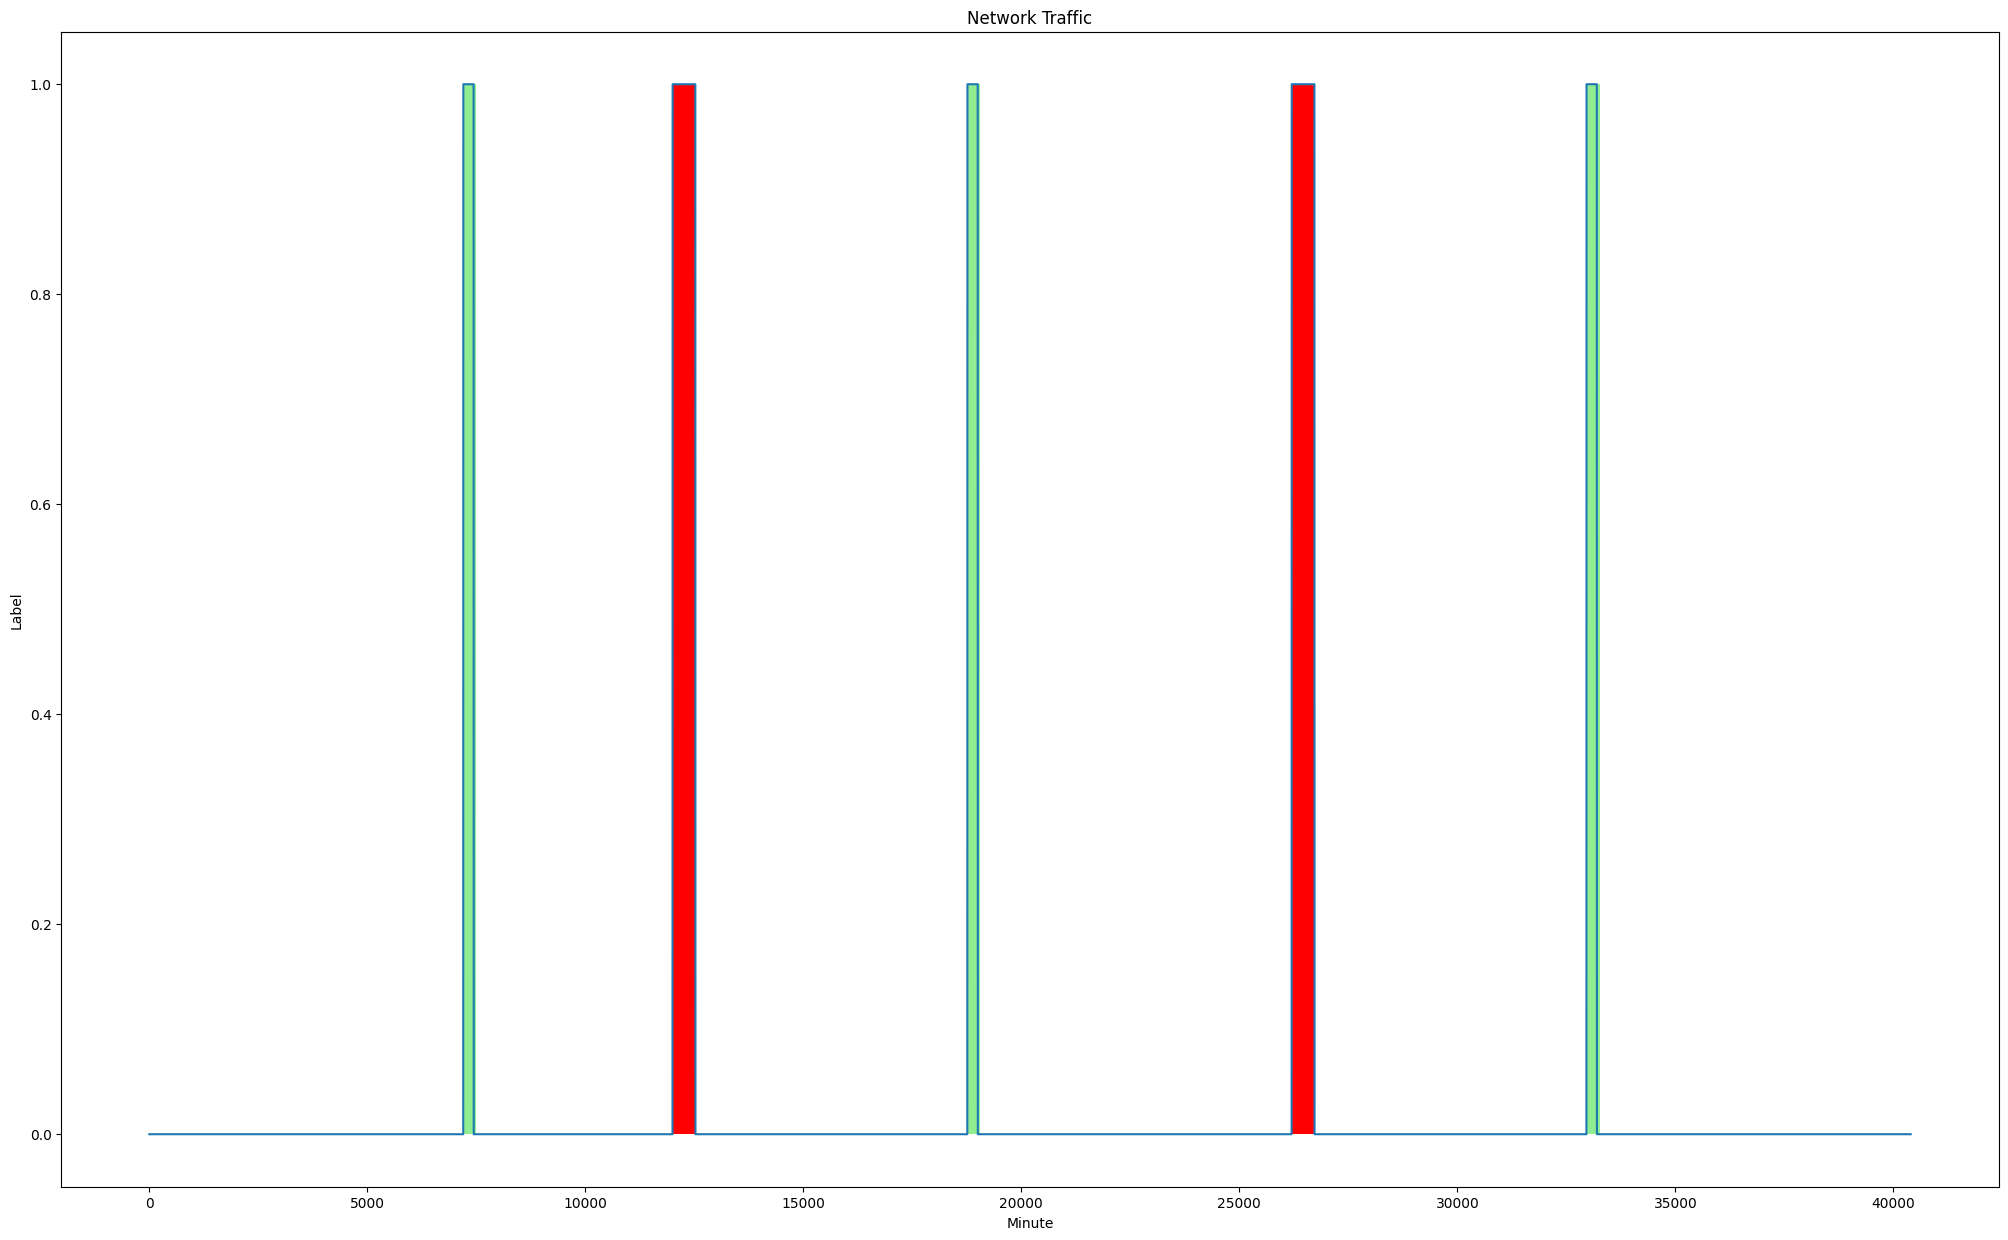

In [55]:
plot_ddos(df)

In [274]:
MatrixProfileManager.global_df = df.copy()

In [319]:
mp_manager = MatrixProfileManager(df.iloc[:,[35, 0, 1, 2, 3]], window_size=60, discord_number=1000, method='mpx', measure='f1')
mp_manager.calculate_mp_seperately_mpx()

In [320]:
mp_dict = {}
for i in range(0, len(mp_manager.mps)):
    print(i)
    mp_dict[f"mp_{i}"] =  np.log10((1 + mp_manager.mps[i])).tolist()

0
1
2
3
4


In [321]:
mp_df = pd.DataFrame(mp_dict)
mp_df

,mp_0,mp_1,mp_2,mp_3,mp_4
0,0.0,0.0,0.0,0.0,7.089164e-08
1,0.0,0.0,0.0,0.0,7.089164e-08
2,0.0,0.0,0.0,0.0,0.000000e+00
3,0.0,0.0,0.0,0.0,0.000000e+00
4,0.0,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...
40336,0.0,0.0,0.0,0.0,0.000000e+00
40337,0.0,0.0,0.0,0.0,0.000000e+00
40338,0.0,0.0,0.0,0.0,0.000000e+00
40339,0.0,0.0,0.0,0.0,0.000000e+00


In [322]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [323]:
model=IsolationForest()
model.fit(mp_df.iloc[:,:])

IsolationForest()

In [324]:
mp_df['scores']=model.decision_function(mp_df.iloc[:,:])
mp_df['anomaly']=model.predict(mp_df.iloc[:, :-1])

In [325]:
anomaly_list = mp_df[mp_df["anomaly"] == -1].index.to_list()
mp_manager.discords = anomaly_list.copy()

In [326]:
mp_manager.obtain_y_vals()
mp_manager.calculate_classification_report()
print(mp_manager.creport)

{'precision': 0.8744416873449131, 'recall': 1.0, 'f1-score': 0.933015620863119, 'support': 1762}


In [327]:
len(anomaly_list)

2015

In [328]:
single_iso_forest_df = df.iloc[:,[35, 0, 1, 2, 3]]
model_2=IsolationForest()
model_2.fit(single_iso_forest_df)

IsolationForest()

In [329]:
single_iso_forest_df['scores']= model_2.decision_function(single_iso_forest_df.iloc[:,:])
single_iso_forest_df['anomaly']= model_2.predict(single_iso_forest_df.iloc[:,:-1])

C:\Users\batuh\AppData\Local\Temp\ipykernel_3220\2535274755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_iso_forest_df['scores']= model_2.decision_function(single_iso_forest_df.iloc[:,:])
C:\Users\batuh\AppData\Local\Temp\ipykernel_3220\2535274755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_iso_forest_df['anomaly']= model_2.predict(single_iso_forest_df.iloc[:,:-1])


In [331]:
anomaly_list = single_iso_forest_df[single_iso_forest_df["anomaly"] == -1].index.to_list()
print(len(anomaly_list))

14641


In [332]:
true_label_list = df[df["Label"] == 1].index.to_list()

In [333]:
y_pred_df = df.copy()
y_pred_df["y_pred"] = np.zeros(len(df))
y_pred_df.iloc[anomaly_list, -1] = 1

In [334]:
from sklearn.metrics import classification_report

In [335]:
print(classification_report(y_pred_df["Label"].to_list(), y_pred_df["y_pred"].to_list()))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     38638
           1       0.12      1.00      0.21      1762

    accuracy                           0.68     40400
   macro avg       0.56      0.83      0.51     40400
weighted avg       0.96      0.68      0.77     40400



In [66]:
import mp_genetic_utils
import pandas as pd



import random as rnd
MatrixProfileManager.THRESHOLD_BASE_ACTIVE = True
MatrixProfileManager.global_df = df.copy()
MatrixProfileManager.threshold = 8
GeneticAlgo.thresholded_mp = True
genetic_algo = GeneticAlgo(df.copy(), max_features=38, population_bag_size=10, fitness="F1")
pop_bag = genetic_algo.initialize_population()
generation_number = 1
for generation in range(generation_number):
    print(f"Generation {generation} is started!")
    
    res = genetic_algo.eval_fit_population(pop_bag)
    best_fit, _, best_solution, f1_score = genetic_algo.find_best(res).values()
    
    if (generation == 0):
        best_fit_global      = best_fit
        best_solution_global = best_solution
        best_f1_global = f1_score
    else:
        if (f1_score >= best_f1_global):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global = f1_score

    new_pop_bag = []
    for i in range(len(genetic_algo.population_bag)):
                # Pick 2 parents from the bag
        pA = genetic_algo.pick_one(pop_bag)
        pB = genetic_algo.pick_one(pop_bag)
        new_element = pA
            # Crossover the parents
        if rnd.random() <= 0.87:
            new_element = genetic_algo.crossover(pA, pB)
            # Mutate the child
        if rnd.random() <= 0.5:
            new_element = genetic_algo.mutation(new_element) 
        new_pop_bag.append(new_element)
            # Set the new bag as the population bag
    pop_bag = genetic_algo.create_population(new_pop_bag)

print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {f1_score}")


FileNotFoundError: [Errno 2] No such file or directory: '../verisetleri/ddos_dataset_on_seconds.csv'

In [48]:
random.randint(0, 3)

3

In [35]:
a_list = list(range(0, len(MatrixProfileManager.global_df)))

In [37]:
len(mp_manager.discords)

635

Genetic Algorithm Process is ready to start


In [42]:
gA = GeneticAlgo(df.copy(), max_features=10, population_bag_size=5, fitness="F1")
first_pop = gA.initialize_population()

MatrixProfileManager.THRESHOLD_BASE_ACTIVE = True
MatrixProfileManager.global_df = df.copy()
MatrixProfileManager.threshold = 5

for pop in first_pop:
    mp_deneme_manager = MatrixProfileManager(pop, window_size=60, discord_number=1000, method='mpx', measure='f1')
    cost, f1_score = mp_deneme_manager.calculate_threshold_based_cost()

Genetic Algorithm Process is ready to start
threshold based discords
threshold based discords
threshold based discords
threshold based discords
threshold based discords
